# 2D Transient Stokes Flow on Open/Closed Channel     

<b>Remarks</b>

##  Import Packages

In [1]:
using BlockArrays
using LinearAlgebra
using UnPack
using LinearSolve 
using SparseArrays
using Ferrite
using FerriteGmsh 
using OrdinaryDiffEq
using DifferentialEquations
using Plots 
using WriteVTK

## Section 1: Introduction 

More later.

<b>Questions</b>:
1. how is solution and time-stepping towardsa this solution affected by the viscosity value;
2. pls. document how pressure increases as time-stepping progresses; 

## Section 2: Generate 2D Mesh 

In [2]:
nels  = (20, 5) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((1.0, 0.25,)) # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);

In [3]:
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

Grid{2, Quadrilateral, Float64} with 100 Quadrilateral cells and 126 nodes

In [4]:
getvertexset(grid, "corner")

OrderedCollections.OrderedSet{VertexIndex} with 1 element:
  VertexIndex((1, 1))

## Section 3: Functions for Assembly of Stiffness Matrix and Load Vector 
Modified tutorial by removing the volumetric source term. 

In [5]:
function assemble_mass_matrix!(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
    # Allocate a buffer for the local matrix and some helpers, together with the assembler.
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # It follows the assembly loop as explained in the basic tutorials.
    mass_assembler = start_assemble(M)
    for cell in CellIterator(dh)
        fill!(Mₑ, 0)
        Ferrite.reinit!(cellvalues_v, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            # Remember that we assemble a vector mass term, hence the dot product.
            # There is only one time derivative on the left hand side, so only one mass block is non-zero.
            for i in 1:n_basefuncs_v
                φᵢ = shape_value(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    φⱼ = shape_value(cellvalues_v, q_point, j)
                    Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                end
            end
        end
        assemble!(mass_assembler, celldofs(cell), Mₑ)
    end

    return M
end

function assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)
    assembler = start_assemble(K)
    ke = zeros(ndofs_per_cell(dh), ndofs_per_cell(dh))
    range_u = dof_range(dh, :u)
    ndofs_u = length(range_u)
    range_p = dof_range(dh, :p)
    ndofs_p = length(range_p)
    ϕᵤ = Vector{Vec{2,Float64}}(undef, ndofs_u)
    ∇ϕᵤ = Vector{Tensor{2,2,Float64,4}}(undef, ndofs_u) # 2-by-2 tensor 
    divϕᵤ = Vector{Float64}(undef, ndofs_u)
    ϕₚ = Vector{Float64}(undef, ndofs_p)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cvu, cell)
        Ferrite.reinit!(cvp, cell)
        ke .= 0
        for qp in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, qp)
            for i in 1:ndofs_u
                ϕᵤ[i] = shape_value(cvu, qp, i)
                ∇ϕᵤ[i] = shape_gradient(cvu, qp, i)
                divϕᵤ[i] = shape_divergence(cvu, qp, i)
            end
            for i in 1:ndofs_p
                ϕₚ[i] = shape_value(cvp, qp, i)
            end
            # u-u
            for (i, I) in pairs(range_u), (j, J) in pairs(range_u)
                ke[I, J] += viscosity*( ∇ϕᵤ[i] ⊡ ∇ϕᵤ[j] ) * dΩ
            end
            # u-p
            for (i, I) in pairs(range_u), (j, J) in pairs(range_p)
                ke[I, J] += ( -divϕᵤ[i] * ϕₚ[j] ) * dΩ
            end
            # p-u
            for (i, I) in pairs(range_p), (j, J) in pairs(range_u)
                ke[I, J] += ( -divϕᵤ[j] * ϕₚ[i] ) * dΩ
            end
        end
        assemble!(assembler, celldofs(cell), ke)
    end
    return K 
end

function setup_mean_constraint(dh, fvp)
    assembler = Ferrite.COOAssembler()
    # All external boundaries
    set = union(
            getfacetset(dh.grid, "left"),
            getfacetset(dh.grid, "right"),
            getfacetset(dh.grid, "bottom"),
            getfacetset(dh.grid, "top"),
    )
    # Allocate buffers
    range_p = dof_range(dh, :p)
    element_dofs = zeros(Int, ndofs_per_cell(dh))
    element_dofs_p = view(element_dofs, range_p)
    element_coords = zeros(Vec{2}, 4) # assuming 2D mesh with quadrilaterals only 
    Ce = zeros(1, length(range_p)) # Local constraint matrix (only 1 row)
    # Loop over all the boundaries
    for (ci, fi) in set
        Ce .= 0
        getcoordinates!(element_coords, dh.grid, ci)
        Ferrite.reinit!(fvp, element_coords, fi)
        celldofs!(element_dofs, dh, ci)
        for qp in 1:getnquadpoints(fvp)
            dΓ = getdetJdV(fvp, qp)
            for i in 1:getnbasefunctions(fvp)
                Ce[1, i] += shape_value(fvp, qp, i) * dΓ
            end
        end
        # Assemble to row 1
        assemble!(assembler, [1], element_dofs_p, Ce)
    end
    C, _ = finish_assemble(assembler)
    # Create an AffineConstraint from the C-matrix
    _, J, V = findnz(C)
    _, constrained_dof_idx = findmax(abs2, V)
    constrained_dof = J[constrained_dof_idx]
    V ./= V[constrained_dof_idx]
    mean_value_constraint = AffineConstraint(
        constrained_dof,
        Pair{Int,Float64}[J[i] => -V[i] for i in 1:length(J) if J[i] != constrained_dof],
        0.0,
    )

    return mean_value_constraint
end

setup_mean_constraint (generic function with 1 method)

## Section 4: Set-up, Assembly and Solve

In [68]:
nelem = 20 # 5 # 20
H = 0.25; L = 4*H 
nels  = (4*nelem, nelem) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((L, H,)) # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

dim = 2 
degree = 2

# Interpolations
ipu = Lagrange{RefQuadrilateral,degree+1}() ^ dim # quadratic for 2 velocity components 
ipp = Lagrange{RefQuadrilateral,degree}()         # linear for scalar pressure 

# Dofs
dh = DofHandler(grid)
add!(dh, :u, ipu)
add!(dh, :p, ipp)
close!(dh) 

# FE values
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ipu, ipg) # observe three arguments - need to document whether this is required 
cvp = CellValues(qr, ipp, ipg) # observe three arguments - need to document whether this is required
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvp = FacetValues(qr_facet, ipp, ipg) # required for pressure constraint 

# Boundary conditions 
ch = ConstraintHandler(dh)

# Ramp the inlet velocity 
vmax = 1. 
vin(t) = min(t * vmax, vmax) #inflow velocity
# vin(t) = vmax 
parabolic_inflow_profile(x,t) = Vec((4*vin(t)*x[2]*(H-x[2]), 0.0))

# Boundary conditions part (1/3): Dirichlet BC for the velocity at the top lid 
inlet = getfacetset(dh.grid, "left")
dbc1 = Dirichlet(:u, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
add!(ch, dbc1)

# Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
wall = union(
    getfacetset(grid, "top"),
    getfacetset(grid, "right"),
    getfacetset(grid, "bottom"),
)
dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
add!(ch, dbc2)
    
# Boundary conditions part (3/3): apply pressure constraint
mean_value_constraint = setup_mean_constraint(dh, fvp)
add!(ch, mean_value_constraint) 
#corner_patch = getvertexset(grid, "corner")
#dbc3 = Dirichlet(:p, corner_patch, (x, t) -> 0)
#add!(ch, dbc3)
    
# Finalize
close!(ch)

# Global tangent matrix and rhs
coupling = [true true; true false] # no coupling between pressure test/trial functions
#coupling = [true true; true true] # no coupling between pressure test/trial functions
K = allocate_matrix(dh, ch; coupling=coupling)
f = zeros(ndofs(dh))

# Assemble system
viscosity = 1e3
assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity); 

# Apply boundary conditions and solve
update!(ch, 2.)
apply!(K, f, ch)
update!(ch, 0.)
u = K \ f;
ustationary = u 

VTKGridFile("init_stokes_2d_channel", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

VTKGridFile for the closed file "init_stokes_2d_channel.vtu".

In [69]:
coupling = [true true; true false] # no coupling between pressure test/trial functions
K = allocate_matrix(dh, ch; coupling=coupling)
viscosity = 1e3
assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity); 

## Section 5: Plot Velocity and Pressure by Hand-Coded Post-Processing 

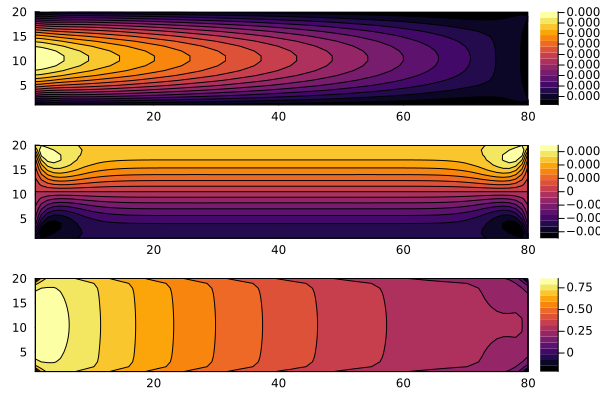

In [70]:
function mypostprocess(u, dh)
 
    area = [] 
    velx = [] 
    vely = []
    pres = []

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_u = dof_range(dh,:u)
        dof_range_p = dof_range(dh,:p)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        ploc = u[celldofs(dh,cell_num)[dof_range_p]]
        Ferrite.reinit!(cvu, cell)

        cellarea = 0. 
        cellvelocity = [0.,0.]
        cellpressure = 0 
    
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            velocity = function_value(cvu, q_point, uloc)
            cellarea += dΩ 
            cellvelocity += velocity*dΩ
        end

        for q_point in 1:getnquadpoints(cvp)
            dΩ = getdetJdV(cvp, q_point)
            pressure = function_value(cvp, q_point, ploc)
            cellpressure += pressure*dΩ
        end

        append!(area, cellarea)
        append!(velx, cellvelocity[1]) 
        append!(vely, cellvelocity[2])
        append!(pres, cellpressure)
    
    end  

    velx2d = reshape(velx, nels)
    vely2d = reshape(vely, nels)
    pres2d = reshape(pres, nels)
    
    return area, velx2d, vely2d, pres2d  
end 

area, velx2d, vely2d, pres2d = mypostprocess(u, dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(pres2d', fill=true)
plot(p1,p2,p3,layout=(3,1))

## Section 6: Hand-Coded Time Stepping

In [35]:
# allocate, assemble and apply bc to mass matrix 
M = allocate_matrix(dh,ch);
M = assemble_mass_matrix!(cvu, cvp, M, dh);

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh,ch);
viscosity = 1e3
K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity);
f = zeros(ndofs(dh));

In [61]:
# set time constants 
T  = 2.0
dt = 1e-1
nsteps = length(dt:dt:T)

A = copy(M)
A.nzval .= M.nzval .+ dt .* K.nzval

rhsdata = get_rhs_data(ch, A);

# set initial guess 
un = zeros(length(f));
# un = ustationary
unhist = Vector{typeof(un)}(undef,nsteps+1)
unhist[1] = un

# apply boundary conditions 
apply!(A, ch);

pvd = paraview_collection("stokes-transient")
VTKGridFile("stokes-transient-0", dh) do vtk
    write_solution(vtk, dh, un)
    pvd[0.0] = vtk
end

for (step, t) in enumerate(dt:dt:T)
    display(t)
    
    #..(1/6) update the Dirichlet boundary condition values.
    update!(ch, t)

    #..(2/6) compute the right-hand-side of the problem.
    b = dt .* f .+ M * un
    
    #..(3/6) apply the boundary conditions of the current time step.
    apply_rhs!(rhsdata, b, ch)

    #..(4/6) solve the time step 
    u = A \ b

    #..(5/6) save the solution
    VTKGridFile("stokes-transient-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
    
    #..(6/6) set the previous solution to the current one and go to the next time step.
    un .= u
    unhist[step+1] = copy(un) 
    
end

vtk_save(pvd);

0.1

0.2

0.3

0.4

0.5

0.6

0.7

0.8

0.9

1.0

1.1

1.2

1.3

1.4

1.5

1.6

1.7

1.8

1.9

2.0

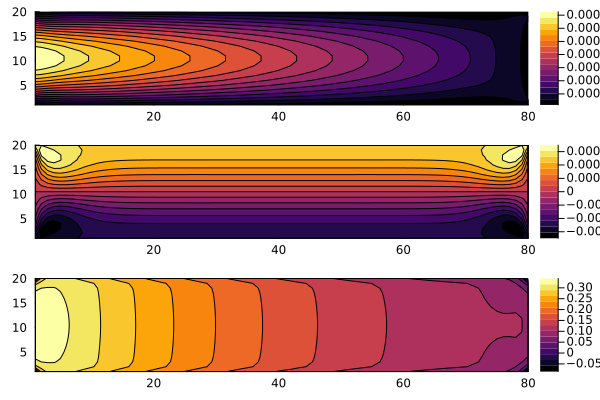

In [60]:
# post-process solution 
area, velx2d, vely2d, pres2d = mypostprocess(unhist[5], dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(pres2d', fill=true)
plot(p1,p2,p3,layout=(3,1))

In [46]:
unhist[1]

36003-element Vector{Float64}:
      0.0
      0.0
      0.0
      0.0
      0.007017706015719958
     -0.004861081467039098
      0.011875000000000002
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0012294219985889406
      ⋮
      0.005986666249194974
      0.0059930430632600135
      0.005530703852755191
      0.004907476310117238
      0.0049021292376562
      0.005533031303312399
      0.008577621682388964
      0.008579330269935109
 -29931.223132487386
  -1731.9707893702878
  -1731.3845851198455
    -24.545001613542997

## Section 7: Time Integration for the Stokes System

<b>Remarks Regarding the Jacobian</b>
1. omitting the Jacobian lead to problem that Jacobian cannot be generated using automatic differention. Analytical Jacobian needs to be supplied;
2. omitting the argumennt jac_prototype is such that the Jacobian J fails to be recognized as sparse and the call nonzeros(J) fails due to a method error;
3. in the construction of the Jacobian, the function apply!(J,ch) is called to elimiated the constrained dofs from the Jacobian. This is done to decouple the constrained dofs in the nonlinear solver from the remaining system; 

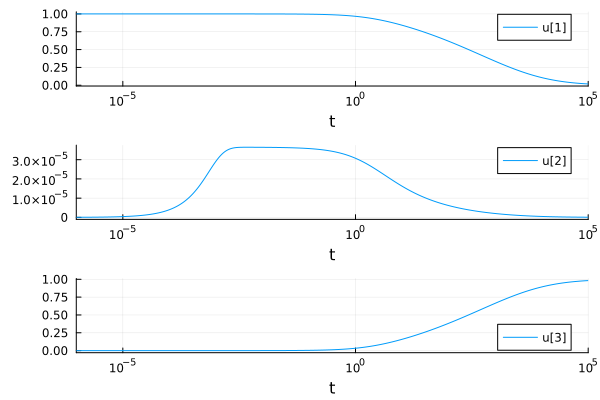

In [13]:
function rober(du, u, p, t)
    y₁, y₂, y₃ = u
    k₁, k₂, k₃ = p
    du[1] = -k₁ * y₁ + k₃ * y₂ * y₃
    du[2] = k₁ * y₁ - k₃ * y₂ * y₃ - k₂ * y₂^2
    du[3] = y₁ + y₂ + y₃ - 1
    nothing
end
M = [1.0 0 0
     0 1.0 0
     0 0 0]
f = ODEFunction(rober, mass_matrix = M)
prob_mm = ODEProblem(f, [1.0, 0.0, 0.0], (0.0, 1e5), (0.04, 3e7, 1e4))
sol = solve(prob_mm, Rodas5(), reltol = 1e-8, abstol = 1e-8)

plot(sol, xscale = :log10, tspan = (1e-6, 1e5), layout = (3, 1))

In [20]:
# deliberatly omitting the Jacobian as the Rober DAE tutorial shows
# Q1: how should the Dirichlet boundary conditions be treated? 

#..pass data to RHS of time integration 
struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    u::Vector
end 

#..right-hand side function for time integration
#..note that modifications to u have local scope only 
function stokes!(du, u_uc, p::RHSparams, t)

    display(t)
    
    @unpack K, ch, u = p
    
    u .= u_uc
    update!(ch, t)
    apply!(u, ch)
    
    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end

#..jacobian function for time integration 
function stokes_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, u = p
    
    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)  
    
    return apply!(J, ch)    
end

#..applies the boundary conditions.. 
function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

# set time constants 
T   = 1e-2 # 2.0
Δt₀ = 1e-3 # 1e-1

# allocate, assemble and apply bc to mass matrix 
M = allocate_matrix(dh);
M = assemble_mass_matrix!(cvu, cvp, M, dh);
apply!(M, ch)

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh,ch);
viscosity = 1e-3
K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess 
uinit = zeros(ndofs(dh))

# set parameters 
p = RHSparams(K, ch, copy(uinit))

rhs = ODEFunction(stokes!, mass_matrix = M; jac = stokes_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
sol = solve(problem, Rodas5(autodiff=false, step_limiter! = ferrite_limiter!), reltol = 1e1, abstol = 1e1);

0.0

0.0

1.4901161193847656e-8

0.0

3.7999999999999996e-7

3.878509998321533e-7

4.83971893787384e-7

4.5704770088195797e-7

1.0e-6

1.0e-6

1.0e-6

1.0e-6

1.0149011611938476e-6

1.0e-6

1.9708284351896407e-6

1.9908862611941763e-6

2.2364570429509816e-6

2.1676708006690904e-6

3.554811671551686e-6

3.554811671551686e-6

3.554811671551686e-6

3.554811671551686e-6

3.5697128327455337e-6

3.554811671551686e-6

6.016439019392624e-6

6.067297534905054e-6

6.689965485586934e-6

6.515551460390772e-6

1.0032778376396261e-5

1.0032778376396261e-5

1.0032778376396261e-5

1.0032778376396261e-5

1.0047679537590109e-5

1.0032778376396261e-5

1.625474761699914e-5

1.638329677348239e-5

1.795714215655791e-5

1.7516296103701017e-5

2.6406381641140678e-5

2.6406381641140678e-5

2.6406381641140678e-5

2.6406381641140678e-5

2.6421282802334525e-5

2.6406381641140678e-5

4.211185530752335e-5

4.2436338652572454e-5

4.6409033833633075e-5

4.5296251721357356e-5

6.773657550004245e-5

6.773657550004245e-5

6.773657550004245e-5

6.773657550004245e-5

6.77514766612363e-5

6.773657550004245e-5

0.00010735747319343068

0.0001081760617753795

0.00011819815679010901

0.00011539089180962762

0.00017200209574580092

0.00017200209574580092

0.00017200209574580092

0.00017200209574580092

0.00017201699690699477

0.00017200209574580092

0.00027193134248765217

0.00027399593327554026

0.00029927300835211806

0.0002921927075200878

0.00043497379769804104

0.00043497379769804104

0.00043497379769804104

0.00043497379769804104

0.0004349886988592349

0.00043497379769804104

0.0006868814486010831

0.0006920859931404461

0.000755805963137716

0.0007379575152764891

0.0010978886684955202

0.0010978886684955202

0.0010978886684955202

0.0010978886684955202

0.001097903569656714

0.0010978886684955202

0.0017078679143444136

0.001720470406335931

0.0018747644863494391

0.0018315455419190658

0.002703097210203134

0.002703097210203134

0.002703097210203134

0.002703097210203134

0.002703112111364328

0.002703097210203134

0.003812613798889146

0.003835536995077423

0.0041161889065581

0.0040375761732277

0.00562287770674527

0.00562287770674527

0.00562287770674527

0.002703097210203134

0.0029250005279403365

0.002929585167177992

0.0029857155494741276

0.0029699930028080474

0.003287053309511561

0.003287053309511561

0.003287053309511561

0.003287053309511561

0.003287068210672755

0.003287053309511561

0.0037958309638541116

0.0038063425777458137

0.003935037743429633

0.00389898924945203

0.004625941873570905

0.004625941873570905

0.004625941873570905

0.004625941873570905

0.004625956774732098

0.004625941873570905

0.005401465092911234

0.00541748781045037

0.005613656192360978

0.005558707937728988

0.006666792450782296

0.006666792450782296

0.006666792450782296

0.006666792450782296

0.00666680735194349

0.006666792450782296

0.007092050686788346

0.007100836745576518

0.007208405697699481

0.007178274816697249

0.0077858930718508485

0.0077858930718508485

0.0077858930718508485

0.0077858930718508485

0.007785907973012042

0.0077858930718508485

0.008517376062605138

0.00853248888586207

0.008717517304241935

0.008665689438057443

0.009710848310677925

0.009710848310677925

0.009710848310677925

0.0077858930718508485

0.008238875495373863

0.008248234350455567

0.008362816128074092

0.008330720901353826

0.008977952081121942

0.008977952081121942

0.008977952081121942

0.008977952081121942

0.008977966982283135

0.008977952081121942

0.009366330290295604

0.009374354388335168

0.00947259454796281

0.009445076732636348

0.01

0.01

0.01

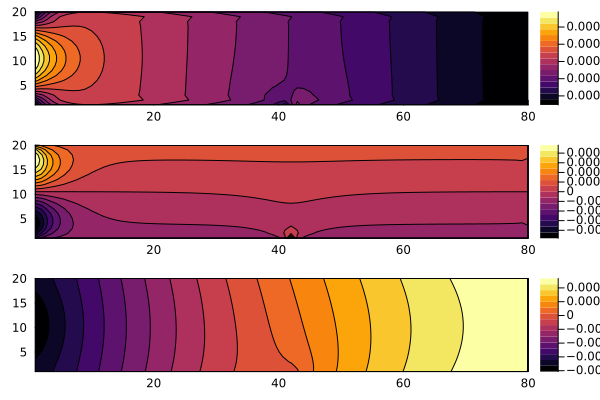

In [30]:
# post-process solution 
un = sol.u[6]
area, velx2d, vely2d, pres2d = mypostprocess(un, dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(pres2d', fill=true)
plot(p1,p2,p3,layout=(3,1))

In [16]:
#..pass data to RHS of time integration 
struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    u::Vector
end

struct FreeDofErrorNorm
    ch::ConstraintHandler
end

In [17]:
function old_stokes!(du, u_uc, p::RHSparams, t)

    display(t)

    @unpack K, ch, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end;

# one is **not** allowed to mutate the input argument u_uc to apply the boundary conditions 
function stokes!(du, u_uc, p::RHSparams, t)

    display(t)
    
    @unpack K, ch, u = p
    
    u .= u_uc
    update!(ch, t)
    apply!(u, ch) # is this necessary or is the limiter instead sufficient for all purposes  
    
    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end;

In [18]:
function old_stokes_jac!(J, u_uc, p, t)

    @unpack K, ch, u = p

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    return apply!(J, ch)
end

function stokes_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, u = p
    
    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    return apply!(J, ch)    
end

stokes_jac! (generic function with 1 method)

In [19]:
# set time constants 
T   = 2.0
Δt₀ = 1e-1

# allocate, assemble and apply bc to mass matrix 
M = allocate_matrix(dh);
M = assemble_mass_matrix!(cvu, cvp, M, dh);
apply!(M, ch)

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh,ch);
viscosity = 1e3
K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)
apply!(K, ch)
K = -K 

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess 
uinit = zeros(ndofs(dh))
uinit = ustationary 

# set parameters 
p = RHSparams(K, ch, copy(uinit))

rhs = ODEFunction(stokes!, mass_matrix = M; jac = stokes_jac!, jac_prototype = jac_sparsity)
# rhs = ODEFunction(stokes!, mass_matrix = M) 
problem = ODEProblem(rhs, uinit, (0.0, T), p);

(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

# sol = solve(problem, ImplicitEuler(),verbose = true)
# sol = solve(problem, ImplicitEuler(autodiff=false); dt = Δt₀, verbose = true)
sol = solve(problem, ImplicitEuler(autodiff=false); dt = Δt₀, 
        adaptive = true, abstol = 1.0e-4, reltol = 1.0e-5,
        verbose = true)

0.0

0.0

0.1

0.1

0.1

0.1

0.1

0.1

0.1

0.1

0.1

0.1

0.05

0.05

0.05

0.05

0.05

0.05

0.05

0.05

0.05

0.05

0.025

0.025

0.025

0.025

0.025

0.025

0.025

0.025

0.025

0.025

0.0125

0.0125

0.0125

0.0125

0.0125

0.0125

0.0125

0.0125

0.0125

0.0125

0.00625

0.00625

0.00625

0.00625

0.00625

0.00625

0.00625

0.00625

0.00625

0.00625

0.003125

0.003125

0.003125

0.003125

0.003125

0.003125

0.003125

0.003125

0.003125

0.003125

0.0015625

0.0015625

0.0015625

0.0015625

0.0015625

0.0015625

0.0015625

0.0015625

0.0015625

0.0015625

0.00078125

0.00078125

0.00078125

0.00078125

0.00078125

0.00078125

0.00078125

0.00078125

0.00078125

0.00078125

0.000390625

0.000390625

0.000390625

0.000390625

0.000390625

0.000390625

0.000390625

0.000390625

0.000390625

0.000390625

0.0001953125

0.0001953125

0.0001953125

0.0001953125

0.0001953125

0.0001953125

0.0001953125

0.0001953125

0.0001953125

0.0001953125

9.765625e-5

9.765625e-5

9.765625e-5

9.765625e-5

9.765625e-5

9.765625e-5

9.765625e-5

9.765625e-5

9.765625e-5

9.765625e-5

4.8828125e-5

4.8828125e-5

4.8828125e-5

4.8828125e-5

4.8828125e-5

4.8828125e-5

4.8828125e-5

4.8828125e-5

4.8828125e-5

4.8828125e-5

2.44140625e-5

2.44140625e-5

2.44140625e-5

2.44140625e-5

2.44140625e-5

2.44140625e-5

2.44140625e-5

2.44140625e-5

2.44140625e-5

2.44140625e-5

1.220703125e-5

1.220703125e-5

1.220703125e-5

1.220703125e-5

1.220703125e-5

1.220703125e-5

1.220703125e-5

1.220703125e-5

1.220703125e-5

1.220703125e-5

6.103515625e-6

6.103515625e-6

6.103515625e-6

6.103515625e-6

6.103515625e-6

6.103515625e-6

6.103515625e-6

6.103515625e-6

6.103515625e-6

6.103515625e-6

3.0517578125e-6

3.0517578125e-6

3.0517578125e-6

3.0517578125e-6

3.0517578125e-6

3.0517578125e-6

3.0517578125e-6

3.0517578125e-6

3.0517578125e-6

3.0517578125e-6

1.52587890625e-6

1.52587890625e-6

1.52587890625e-6

1.52587890625e-6

1.52587890625e-6

1.52587890625e-6

1.52587890625e-6

1.52587890625e-6

1.52587890625e-6

1.52587890625e-6

7.62939453125e-7

7.62939453125e-7

7.62939453125e-7

7.62939453125e-7

7.62939453125e-7

7.62939453125e-7

7.62939453125e-7

7.62939453125e-7

7.62939453125e-7

7.62939453125e-7

3.814697265625e-7

3.814697265625e-7

3.814697265625e-7

3.814697265625e-7

3.814697265625e-7

3.814697265625e-7

3.814697265625e-7

3.814697265625e-7

3.814697265625e-7

3.814697265625e-7

1.9073486328125e-7

1.9073486328125e-7

1.9073486328125e-7

1.9073486328125e-7

1.9073486328125e-7

1.9073486328125e-7

1.9073486328125e-7

1.9073486328125e-7

1.9073486328125e-7

1.9073486328125e-7

9.5367431640625e-8

9.5367431640625e-8

9.5367431640625e-8

9.5367431640625e-8

9.5367431640625e-8

9.5367431640625e-8

9.5367431640625e-8

9.5367431640625e-8

9.5367431640625e-8

9.5367431640625e-8

4.76837158203125e-8

4.76837158203125e-8

4.76837158203125e-8

4.76837158203125e-8

4.76837158203125e-8

4.76837158203125e-8

4.76837158203125e-8

4.76837158203125e-8

4.76837158203125e-8

4.76837158203125e-8

2.384185791015625e-8

2.384185791015625e-8

2.384185791015625e-8

2.384185791015625e-8

2.384185791015625e-8

2.384185791015625e-8

2.384185791015625e-8

2.384185791015625e-8

2.384185791015625e-8

2.384185791015625e-8

1.1920928955078126e-8

1.1920928955078126e-8

1.1920928955078126e-8

1.1920928955078126e-8

1.1920928955078126e-8

1.1920928955078126e-8

1.1920928955078126e-8

1.1920928955078126e-8

1.1920928955078126e-8

1.1920928955078126e-8

5.960464477539063e-9

5.960464477539063e-9

5.960464477539063e-9

5.960464477539063e-9

5.960464477539063e-9

5.960464477539063e-9

5.960464477539063e-9

5.960464477539063e-9

5.960464477539063e-9

5.960464477539063e-9

2.9802322387695314e-9

2.9802322387695314e-9

2.9802322387695314e-9

2.9802322387695314e-9

2.9802322387695314e-9

2.9802322387695314e-9

2.9802322387695314e-9

2.9802322387695314e-9

2.9802322387695314e-9

2.9802322387695314e-9

1.4901161193847657e-9

1.4901161193847657e-9

1.4901161193847657e-9

1.4901161193847657e-9

1.4901161193847657e-9

1.4901161193847657e-9

1.4901161193847657e-9

1.4901161193847657e-9

1.4901161193847657e-9

1.4901161193847657e-9

7.450580596923829e-10

7.450580596923829e-10

7.450580596923829e-10

7.450580596923829e-10

7.450580596923829e-10

7.450580596923829e-10

7.450580596923829e-10

7.450580596923829e-10

7.450580596923829e-10

7.450580596923829e-10

3.7252902984619143e-10

3.7252902984619143e-10

3.7252902984619143e-10

1.8626451492309571e-10

1.8626451492309571e-10

1.8626451492309571e-10

1.8626451492309571e-10

1.8626451492309571e-10

1.8626451492309571e-10

9.313225746154786e-11

9.313225746154786e-11

9.313225746154786e-11

9.313225746154786e-11

4.656612873077393e-11

4.656612873077393e-11

4.656612873077393e-11

4.656612873077393e-11

4.656612873077393e-11

4.656612873077393e-11

2.3283064365386964e-11

2.3283064365386964e-11

2.3283064365386964e-11

2.3283064365386964e-11

2.3283064365386964e-11

1.1641532182693482e-11

1.1641532182693482e-11

1.1641532182693482e-11

5.820766091346741e-12

5.820766091346741e-12

5.820766091346741e-12

2.9103830456733705e-12

2.9103830456733705e-12

2.9103830456733705e-12

2.9103830456733705e-12

2.9103830456733705e-12

2.9103830456733705e-12

1.4551915228366853e-12

1.4551915228366853e-12

1.4551915228366853e-12

1.4551915228366853e-12

1.4551915228366853e-12

1.4551915228366853e-12

1.4551915228366853e-12

1.4551915228366853e-12

1.4551915228366853e-12

1.4551915228366853e-12

7.275957614183426e-13

7.275957614183426e-13

7.275957614183426e-13

7.275957614183426e-13

7.275957614183426e-13

7.275957614183426e-13

7.275957614183426e-13

7.275957614183426e-13

7.275957614183426e-13

7.275957614183426e-13

3.637978807091713e-13

3.637978807091713e-13

3.637978807091713e-13

3.637978807091713e-13

1.8189894035458566e-13

1.8189894035458566e-13

1.8189894035458566e-13

1.8189894035458566e-13

1.8189894035458566e-13

1.8189894035458566e-13

1.8189894035458566e-13

9.094947017729283e-14

9.094947017729283e-14

9.094947017729283e-14

9.094947017729283e-14

9.094947017729283e-14

4.5474735088646414e-14

4.5474735088646414e-14

4.5474735088646414e-14

4.5474735088646414e-14

4.5474735088646414e-14

4.5474735088646414e-14

2.2737367544323207e-14

2.2737367544323207e-14

2.2737367544323207e-14

1.1368683772161604e-14

1.1368683772161604e-14

1.1368683772161604e-14

5.684341886080802e-15

5.684341886080802e-15

5.684341886080802e-15

5.684341886080802e-15

5.684341886080802e-15

2.842170943040401e-15

2.842170943040401e-15

2.842170943040401e-15

1.4210854715202005e-15

1.4210854715202005e-15

1.4210854715202005e-15

1.4210854715202005e-15

1.4210854715202005e-15

1.4210854715202005e-15

7.105427357601002e-16

7.105427357601002e-16

7.105427357601002e-16

3.552713678800501e-16

3.552713678800501e-16

3.552713678800501e-16

3.552713678800501e-16

3.552713678800501e-16

1.7763568394002506e-16

1.7763568394002506e-16

1.7763568394002506e-16

8.881784197001253e-17

8.881784197001253e-17

8.881784197001253e-17

8.881784197001253e-17

4.4408920985006264e-17

4.4408920985006264e-17

4.4408920985006264e-17

2.2204460492503132e-17

2.2204460492503132e-17

2.2204460492503132e-17

2.2204460492503132e-17

1.1102230246251566e-17

1.1102230246251566e-17

1.1102230246251566e-17

1.1102230246251566e-17

1.1102230246251566e-17

5.551115123125783e-18

5.551115123125783e-18

5.551115123125783e-18

5.551115123125783e-18

5.551115123125783e-18

2.7755575615628915e-18

2.7755575615628915e-18

2.7755575615628915e-18

2.7755575615628915e-18

2.7755575615628915e-18

1.3877787807814458e-18

1.3877787807814458e-18

1.3877787807814458e-18

1.3877787807814458e-18

1.3877787807814458e-18

1.3877787807814458e-18

1.3877787807814458e-18

1.3877787807814458e-18

1.3877787807814458e-18

1.3877787807814458e-18

6.938893903907229e-19

6.938893903907229e-19

6.938893903907229e-19

6.938893903907229e-19

3.4694469519536144e-19

3.4694469519536144e-19

3.4694469519536144e-19

1.7347234759768072e-19

1.7347234759768072e-19

1.7347234759768072e-19

1.7347234759768072e-19

8.673617379884036e-20

8.673617379884036e-20

8.673617379884036e-20

8.673617379884036e-20

4.336808689942018e-20

4.336808689942018e-20

4.336808689942018e-20

4.336808689942018e-20

4.336808689942018e-20

2.168404344971009e-20

2.168404344971009e-20

2.168404344971009e-20

2.168404344971009e-20

1.0842021724855045e-20

1.0842021724855045e-20

1.0842021724855045e-20

1.0842021724855045e-20

1.0842021724855045e-20

5.4210108624275225e-21

5.4210108624275225e-21

5.4210108624275225e-21

2.7105054312137612e-21

2.7105054312137612e-21

2.7105054312137612e-21

2.7105054312137612e-21

2.7105054312137612e-21

2.7105054312137612e-21

2.7105054312137612e-21

2.7105054312137612e-21

2.7105054312137612e-21

2.7105054312137612e-21

1.3552527156068806e-21

1.3552527156068806e-21

1.3552527156068806e-21

1.3552527156068806e-21

6.776263578034403e-22

6.776263578034403e-22

6.776263578034403e-22

6.776263578034403e-22

3.3881317890172015e-22

3.3881317890172015e-22

3.3881317890172015e-22

3.3881317890172015e-22

1.6940658945086008e-22

1.6940658945086008e-22

1.6940658945086008e-22

1.6940658945086008e-22

8.470329472543004e-23

8.470329472543004e-23

8.470329472543004e-23

8.470329472543004e-23

4.235164736271502e-23

4.235164736271502e-23

4.235164736271502e-23

4.235164736271502e-23

2.117582368135751e-23

2.117582368135751e-23

2.117582368135751e-23

1.0587911840678755e-23

1.0587911840678755e-23

1.0587911840678755e-23

5.2939559203393774e-24

5.2939559203393774e-24

5.2939559203393774e-24

5.2939559203393774e-24

5.2939559203393774e-24

2.6469779601696887e-24

2.6469779601696887e-24

2.6469779601696887e-24

1.3234889800848444e-24

1.3234889800848444e-24

1.3234889800848444e-24

1.3234889800848444e-24

1.3234889800848444e-24

6.617444900424222e-25

6.617444900424222e-25

6.617444900424222e-25

6.617444900424222e-25

6.617444900424222e-25

6.617444900424222e-25

3.308722450212111e-25

3.308722450212111e-25

3.308722450212111e-25

1.6543612251060554e-25

1.6543612251060554e-25

1.6543612251060554e-25

1.6543612251060554e-25

1.6543612251060554e-25

1.6543612251060554e-25

1.6543612251060554e-25

8.271806125530277e-26

8.271806125530277e-26

8.271806125530277e-26

8.271806125530277e-26

4.1359030627651386e-26

4.1359030627651386e-26

4.1359030627651386e-26

2.0679515313825693e-26

2.0679515313825693e-26

2.0679515313825693e-26

2.0679515313825693e-26

2.0679515313825693e-26

2.0679515313825693e-26

2.0679515313825693e-26

2.0679515313825693e-26

2.0679515313825693e-26

2.0679515313825693e-26

1.0339757656912847e-26

1.0339757656912847e-26

1.0339757656912847e-26

1.0339757656912847e-26

5.169878828456423e-27

5.169878828456423e-27

5.169878828456423e-27

5.169878828456423e-27

2.5849394142282116e-27

2.5849394142282116e-27

2.5849394142282116e-27

1.2924697071141058e-27

1.2924697071141058e-27

1.2924697071141058e-27

1.2924697071141058e-27

1.2924697071141058e-27

1.2924697071141058e-27

1.2924697071141058e-27

6.462348535570529e-28

6.462348535570529e-28

6.462348535570529e-28

6.462348535570529e-28

6.462348535570529e-28

3.2311742677852645e-28

3.2311742677852645e-28

3.2311742677852645e-28

3.2311742677852645e-28

1.6155871338926323e-28

1.6155871338926323e-28

1.6155871338926323e-28

1.6155871338926323e-28

1.6155871338926323e-28

8.077935669463161e-29

8.077935669463161e-29

8.077935669463161e-29

8.077935669463161e-29

8.077935669463161e-29

8.077935669463161e-29

8.077935669463161e-29

4.0389678347315807e-29

4.0389678347315807e-29

4.0389678347315807e-29

4.0389678347315807e-29

2.0194839173657903e-29

2.0194839173657903e-29

2.0194839173657903e-29

1.0097419586828952e-29

1.0097419586828952e-29

1.0097419586828952e-29

1.0097419586828952e-29

1.0097419586828952e-29

5.048709793414476e-30

5.048709793414476e-30

5.048709793414476e-30

5.048709793414476e-30

5.048709793414476e-30

2.524354896707238e-30

2.524354896707238e-30

2.524354896707238e-30

1.262177448353619e-30

1.262177448353619e-30

1.262177448353619e-30

1.262177448353619e-30

1.262177448353619e-30

1.262177448353619e-30

1.262177448353619e-30

6.310887241768095e-31

6.310887241768095e-31

6.310887241768095e-31

6.310887241768095e-31

6.310887241768095e-31

3.1554436208840474e-31

3.1554436208840474e-31

3.1554436208840474e-31

1.5777218104420237e-31

1.5777218104420237e-31

1.5777218104420237e-31

1.5777218104420237e-31

7.888609052210118e-32

7.888609052210118e-32

7.888609052210118e-32

3.944304526105059e-32

3.944304526105059e-32

3.944304526105059e-32

3.944304526105059e-32

3.944304526105059e-32

1.9721522630525296e-32

1.9721522630525296e-32

1.9721522630525296e-32

1.9721522630525296e-32

9.860761315262648e-33

9.860761315262648e-33

9.860761315262648e-33

9.860761315262648e-33

9.860761315262648e-33

9.860761315262648e-33

9.860761315262648e-33

4.930380657631324e-33

4.930380657631324e-33

4.930380657631324e-33

4.930380657631324e-33

2.465190328815662e-33

2.465190328815662e-33

2.465190328815662e-33

2.465190328815662e-33

1.232595164407831e-33

1.232595164407831e-33

1.232595164407831e-33

1.232595164407831e-33

1.232595164407831e-33

1.232595164407831e-33

6.162975822039155e-34

LoadError: SingularException(0)

In [20]:
# timestepper = ImplicitEuler(autodiff=false)
timestepper = ImplicitEuler()
# timestepper = Euler()

integrator = init(
    problem, timestepper; dt = Δt₀,
    adaptive = true, abstol = 1.0e-4, reltol = 1.0e-5,
    progress = true, progress_steps = 1,
    verbose = true, internalnorm = FreeDofErrorNorm(ch), d_discontinuities = [1.0]
);

pvd = paraview_collection("stokes-channel-2d")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("stokes-channel-2d$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end
vtk_save(pvd);

0.0

0.0

0.1

0.1

0.1

0.1

0.1

0.0

0.12000000000000001

0.12000000000000001

0.12000000000000001

0.10400000000000001

0.10400000000000001

0.10400000000000001

0.1008

0.1008

0.1008

0.10016

0.10016

0.10016

0.10003200000000001

0.10003200000000001

0.10003200000000001

0.1

0.10006452995746526

0.10006452995746526

0.10006452995746526

0.10003850599149305

0.10003850599149305

0.10003850599149305

0.10003360605953886

0.10003360605953886

0.10003360605953886

0.10003200000000001

0.1000360276300394

0.1000360276300394

0.1000360276300394

0.10003360605953886

0.10004050287804332

0.10004050287804332

0.10004050287804332

0.1000360276300394

0.10005252709805629

0.10005252709805629

0.10005252709805629

0.10004050287804332

0.10008895024833803

0.10008895024833803

0.10008895024833803

0.10005252709805629

0.10035372342449832

0.10035372342449832

0.10008895024833803

0.10300145518610124

0.10300145518610124

0.10035372342449832

0.12947877280213044

0.12947877280213044

0.10300145518610124

0.3942519489624223

0.3942519489624223

0.12947877280213044

1.0

1.0

0.3942519489624223

1.0

2.0

2.0

1.0